# Model import using the Petab format

In [1]:
import pypesto
import amici
import petab

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Download benchmark models - Note: 200MB :(
!git clone --depth 1 https://github.com/LoosC/Benchmark-Models.git tmp/benchmark-models || (cd tmp/benchmark-models && git pull)

fatal: destination path 'tmp/benchmark-models' already exists and is not an empty directory.
Already up to date.


## Manage PETAB model

In [2]:
folder_base = "tmp/benchmark-models/hackathon_contributions_new_data_format/"
model_name = "Zheng_PNAS2012"
model_name = "Boehm_JProteomeRes2014"

petab_problem = petab.Problem.from_folder(folder_base + model_name)

# print(petab.lint.check_measurement_df(manager.measurement_df))
petab_problem.get_optimization_to_simulation_parameter_mapping()


[['Epo_degradation_BaF3',
  'k_exp_hetero',
  'k_exp_homo',
  'k_imp_hetero',
  'k_imp_homo',
  'k_phos',
  'ratio',
  'sd_pSTAT5A_rel',
  'sd_pSTAT5B_rel',
  'sd_rSTAT5A_rel',
  'specC17']]

## Import model to AMICI

In [3]:
importer = pypesto.PetabImporter(petab_problem)

model = importer.create_model()
print(model.getParameterScale())
print("Model parameters:", list(model.getParameterIds()), '\n')
print("Model const parameters:", list(model.getFixedParameterIds()), '\n')
print("Model outputs:   ", list(model.getObservableIds()), '\n')
print("Model states:    ", list(model.getStateIds()), '\n')

<amici.amici.ParameterScalingVector; proxy of <Swig Object of type 'std::vector< enum amici::ParameterScaling,std::allocator< enum amici::ParameterScaling > > *' at 0x7fb5e25ed510> >
Model parameters: ['Epo_degradation_BaF3', 'k_exp_hetero', 'k_exp_homo', 'k_imp_hetero', 'k_imp_homo', 'k_phos', 'ratio', 'noiseParameter1_pSTAT5A_rel', 'noiseParameter1_pSTAT5B_rel', 'noiseParameter1_rSTAT5A_rel', 'specC17'] 

Model const parameters: [] 

Model outputs:    ['observable_pSTAT5A_rel', 'observable_pSTAT5B_rel', 'observable_rSTAT5A_rel'] 

Model states:     ['STAT5A', 'STAT5B', 'pApB', 'pApA', 'pBpB', 'nucpApA', 'nucpApB', 'nucpBpB'] 



## Create objective function

In [4]:
obj = importer.create_objective()

#print(amici.getDataObservablesAsDataFrame(obj.amici_model, edatas))
#print(edatas[0].fixedParametersPreequilibration)
#print(obj.dim, obj.x_names, len(obj.x_ids), obj.opt_to_sim_par_mapping)
#print(edatas[0].fixedParametersPreequilibration, edatas[0].fixedParameters)

print("Nominal parameter values:\n", petab_problem.x_nominal)

obj(petab_problem.x_nominal)

Nominal parameter values:
 [-1.5689175884, -4.9997048936, -2.2096987817, -1.7860065475, 4.9901140088, 4.1977354885, 0.693, 0.5857552706, 0.8189828192, 0.49868440399999997, 0.107]


138.22199805132536

## Run optimization

In [5]:
optimizer = pypesto.ScipyOptimizer()

problem = importer.create_problem(obj)

engine = pypesto.SingleCoreEngine()
# engine = pypesto.MultiProcessEngine()

# do the optimization
result = pypesto.minimize(problem=problem, optimizer=optimizer,
                          n_starts=5, engine=engine)

## Visualize

No handles with labels found to put in legend.


[149.58782960170979, 150.66628796867806, 179.2318706628523, 191.78626009295692, 225.1187284118354]


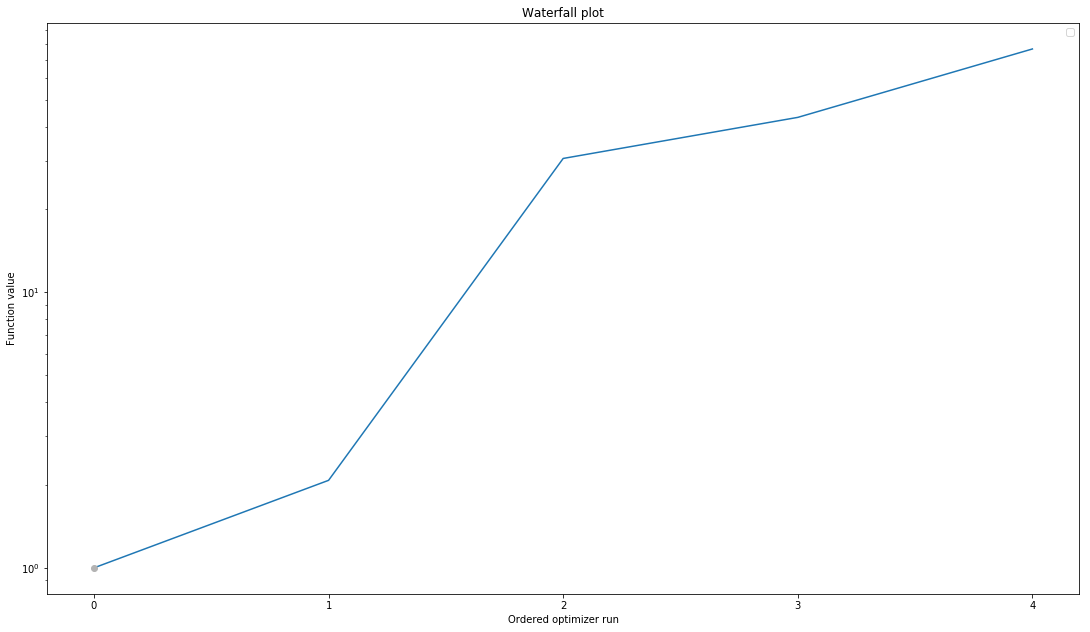

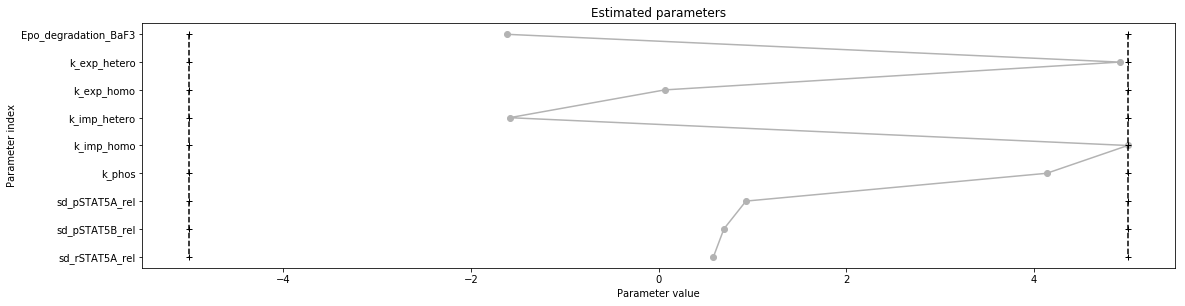

In [6]:
import pypesto.visualize

pypesto.visualize.waterfall(result)
pypesto.visualize.parameters(result)

print(result.optimize_result.get_for_key('fval'))

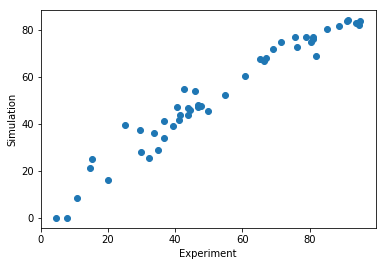

In [7]:
rdatas = obj(result.optimize_result.get_for_key('x')[0], return_dict=True)['rdatas']
df = importer.rdatas_to_measurement_df(rdatas)

plt.xlabel("Experiment")
plt.ylabel("Simulation")

# note: here we still assume that both files have the same order
plt.scatter(petab_problem.measurement_df['measurement'], df['measurement'])

# print(df)